# Logo Detection with U-Net

This notebook demonstrates a complete pipeline for training a U-Net model for logo detection, including:

1. Data loading and preprocessing
2. Model architecture
3. Training with Weights & Biases (wandb) tracking
4. Evaluation and visualization
5. Inference on new images

## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import wandb
from PIL import Image
import torchvision.transforms as transforms

# Check for GPU
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

Using device: cuda:3


## 2. Import Custom Modules

Let's import our custom modules for data loading, model architecture, training, and utilities.

In [2]:
# Add this notebook's directory to the path
notebook_dir = os.path.abspath('')
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

# Import custom modules
from dataloader import LogoDatasetCombined, get_logo_dataloader
from models import UNet
from loss_functions import DiceLoss, IoULoss, FocalLoss, CombinedLoss
from trainer import LogoDetectionTrainer
import utils

## 3. Configure Data Paths and Parameters

Set up the data paths, image size, batch size, and other parameters.

In [ ]:
# Enable debug mode
DEBUG = False  # Set to True to enable detailed debugging output

# Function to configure logging
def setup_logging():
    import logging
    import sys
    
    # Create logger
    logger = logging.getLogger('logo_detection')
    logger.setLevel(logging.DEBUG if DEBUG else logging.INFO)
    
    # Create console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.DEBUG if DEBUG else logging.INFO)
    
    # Create file handler
    file_handler = logging.FileHandler('logo_detection.log')
    file_handler.setLevel(logging.DEBUG)
    
    # Create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)
    
    # Add handlers to logger
    logger.addHandler(console_handler)
    logger.addHandler(file_handler)
    
    return logger

# Setup logging
logger = setup_logging()
logger.info("Starting Logo Detection Pipeline")

In [4]:
# Data paths
# Note: Update these paths to match your actual data locations
# Keeping the correct format, but modify to match your setup
root_dir = '/mnt1/peter/datasets/'
train_filelist = '/mnt1/peter/datasets/train/filelist-logosonly.txt'
val_filelist = '/mnt1/peter/datasets/test/filelist.txt'

# Parameters
image_size = 512  # Input image size
batch_size = 4    # Batch size for training
num_epochs = 30   # Number of training epochs
learning_rate = 1e-4  # Initial learning rate
num_workers = 2   # Number of dataloader workers (reduced to help with debugging)

# Troubleshooting options
# If you encounter batch size issues, try setting these flags:
reduce_batch_size = False  # Set to True to automatically reduce batch size if errors occur
check_files_first = True  # Set to True to verify files exist before creating the dataset

# Print configuration
print(f"Configuration:")
print(f"- Root directory: {root_dir}")
print(f"- Train filelist: {train_filelist}")
print(f"- Validation filelist: {val_filelist}")
print(f"- Image size: {image_size}px")
print(f"- Batch size: {batch_size}")
print(f"- Number of epochs: {num_epochs}")
print(f"- Learning rate: {learning_rate}")
print(f"- Number of workers: {num_workers}")
# print(f"- Debug mode: {'Enabled' if DEBUG else 'Disabled'}")

# Create output directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)
# os.makedirs('logs', exist_ok=True)

# logger.info(f"Configuration set: image_size={image_size}, batch_size={batch_size}, num_epochs={num_epochs}")

Configuration:
- Root directory: /mnt1/peter/datasets/
- Train filelist: /mnt1/peter/datasets/train/filelist-logosonly.txt
- Validation filelist: /mnt1/peter/datasets/test/filelist.txt
- Image size: 512px
- Batch size: 4
- Number of epochs: 30
- Learning rate: 0.0001
- Number of workers: 2


In [5]:
# Check filelists before loading datasets
if check_files_first:
    print("Checking filelists...")
    
    def check_filelist(filelist_path):
        if not os.path.exists(filelist_path):
            print(f"ERROR: Filelist not found: {filelist_path}")
            return False
        
        # Read filelist
        try:
            with open(filelist_path, 'r') as f:
                file_paths = [line.strip() for line in f.readlines()]
            print(f"Found {len(file_paths)} entries in {filelist_path}")
            
            # Check a few random files
            import random
            sample_size = min(5, len(file_paths))
            sample_paths = random.sample(file_paths, sample_size)
            
            print(f"Checking {sample_size} random files:")
            for path in sample_paths:
                # Get full path
                if 'train' in filelist_path:
                    full_path = os.path.join('/mnt1/peter/datasets/train/', path.lstrip('./'))
                else:
                    full_path = os.path.join('/mnt1/peter/datasets/test/', path.lstrip('./'))
                
                if os.path.exists(full_path):
                    print(f"  ✓ {full_path}")
                else:
                    print(f"  ✗ {full_path} (NOT FOUND)")
            
            return True
        except Exception as e:
            print(f"Error checking filelist {filelist_path}: {e}")
            return False
    
    train_ok = check_filelist(train_filelist)
    val_ok = check_filelist(val_filelist)
    
    if not train_ok or not val_ok:
        print("WARNING: Issues detected with filelists. Please check paths and file existence.")
    else:
        print("Filelists verified successfully!")

Checking filelists...
Found 833 entries in /mnt1/peter/datasets/train/filelist-logosonly.txt
Checking 5 random files:
  ✓ /mnt1/peter/datasets/train/000000/000000415.png
  ✓ /mnt1/peter/datasets/train/000001/000001427.png
  ✓ /mnt1/peter/datasets/train/000001/000001463.png
  ✓ /mnt1/peter/datasets/train/000000/000000715.png
  ✓ /mnt1/peter/datasets/train/000001/000001932.png
Found 1402 entries in /mnt1/peter/datasets/test/filelist.txt
Checking 5 random files:
  ✓ /mnt1/peter/datasets/test/000000/000000289.png
  ✓ /mnt1/peter/datasets/test/000000/000000564.png
  ✓ /mnt1/peter/datasets/test/000001/000001598.png
  ✓ /mnt1/peter/datasets/test/000001/000001065.png
  ✓ /mnt1/peter/datasets/test/000000/000000579.png
Filelists verified successfully!


## 4. Load and Explore the Dataset

Let's load the training and validation datasets and visualize some examples.

In [6]:
# Function to verify dataset integrity
def verify_dataset(dataset, num_samples=5):
    """Check a few samples from the dataset to ensure they can be loaded properly"""
    print(f"Verifying dataset with {len(dataset)} samples...")
    
    # Check a few random samples
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    for i, idx in enumerate(indices):
        try:
            sample = dataset[idx]
            print(f"Sample {i+1}/{len(indices)} (idx={idx}):")
            print(f"  Image shape: {sample['image'].shape if 'image' in sample and sample['image'] is not None else 'None'}")
            print(f"  Mask shape: {sample['mask'].shape if 'mask' in sample and sample['mask'] is not None else 'None'}")
            print(f"  Image name: {sample['image_name'] if 'image_name' in sample else 'None'}")
            
            # Verify tensor values
            if 'image' in sample and sample['image'] is not None:
                print(f"  Image min/max: {sample['image'].min().item():.3f}/{sample['image'].max().item():.3f}")
            if 'mask' in sample and sample['mask'] is not None:
                print(f"  Mask min/max: {sample['mask'].min().item():.3f}/{sample['mask'].max().item():.3f}")
                print(f"  Mask has logos: {'Yes' if sample['mask'].max() > 0 else 'No'}")
                
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
    
    print("Dataset verification complete.")

In [7]:
# Load dataloaders with error handling
try:
    print("Loading training dataset...")
    train_dataloader, train_dataset = get_logo_dataloader(
        root_dir=root_dir,
        filelist_path=train_filelist,
        batch_size=batch_size,
        image_size=image_size,
        num_workers=num_workers,
        shuffle=True
    )
    
    print("Loading validation dataset...")
    val_dataloader, val_dataset = get_logo_dataloader(
        root_dir=root_dir,
        filelist_path=val_filelist,
        batch_size=batch_size,
        image_size=image_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Verify datasets
    print("\nVerifying training dataset:")
    verify_dataset(train_dataset)
    print("\nVerifying validation dataset:")
    verify_dataset(val_dataset)
    
except Exception as e:
    print(f"Error loading datasets: {e}")

Loading training dataset...
Found 833 images in /mnt1/peter/datasets/train/filelist-logosonly.txt
Found 833 valid images with masks, skipped 0 invalid entries
Processed 833 images with masks
Loading validation dataset...
Found 1402 images in /mnt1/peter/datasets/test/filelist.txt
Found 1402 valid images with masks, skipped 0 invalid entries
Processed 1402 images with masks
Training dataset size: 833
Validation dataset size: 1402

Verifying training dataset:
Verifying dataset with 833 samples...
Sample 1/5 (idx=610):
  Image shape: torch.Size([3, 512, 512])
  Mask shape: torch.Size([1, 512, 512])
  Image name: 000000837
  Image min/max: -2.001/2.640
  Mask min/max: 0.000/1.000
  Mask has logos: Yes
Sample 2/5 (idx=820):
  Image shape: torch.Size([3, 512, 512])
  Mask shape: torch.Size([1, 512, 512])
  Image name: 000000206
  Image min/max: -2.118/2.640
  Mask min/max: 0.000/1.000
  Mask has logos: Yes
Sample 3/5 (idx=290):
  Image shape: torch.Size([3, 512, 512])
  Mask shape: torch.Siz

In [8]:
# Test batch loading
try:
    print("Testing batch loading from training dataloader...")
    batch = next(iter(train_dataloader))
    print(f"Successfully loaded a batch with {len(batch['image'])} images.")
    print(f"Image batch shape: {batch['image'].shape}")
    print(f"Mask batch shape: {batch['mask'].shape}")
except Exception as e:
    print(f"Error loading batch: {e}")
    print("\nTroubleshooting options:")
    print("1. Try reducing batch_size to 1 to isolate problematic samples")
    print("2. Check for corrupted images or masks in the dataset")
    print("3. Verify all images and masks have consistent dimensions")

Testing batch loading from training dataloader...
Successfully loaded a batch with 4 images.
Image batch shape: torch.Size([4, 3, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


### Visualize some training examples

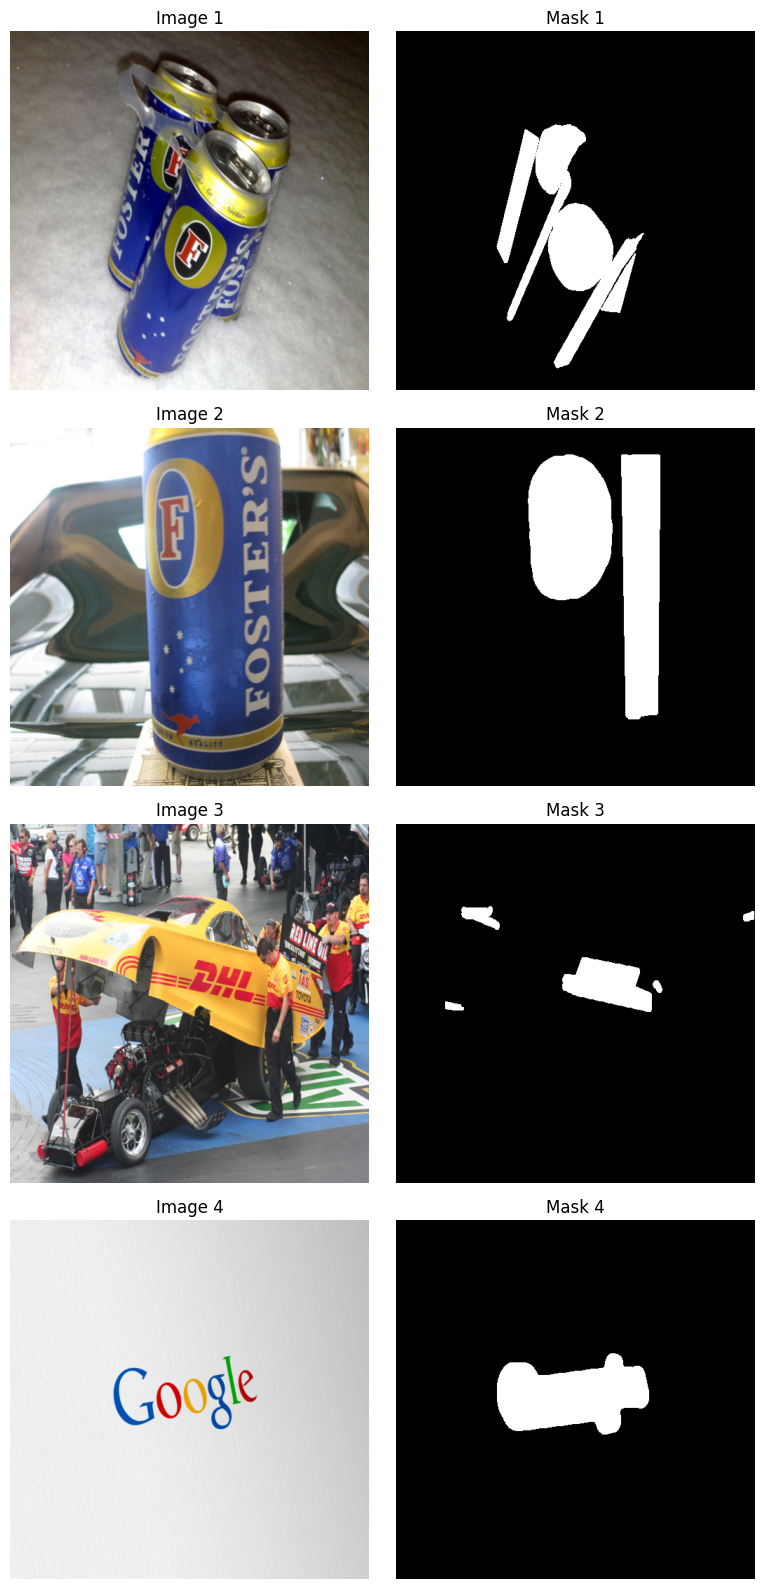

In [9]:
# Get a batch from the dataloader
batch = next(iter(train_dataloader))

# Visualize the batch
fig = utils.visualize_batch(batch, num_samples=4)
plt.show()

## 5. Initialize and Configure the U-Net Model

In [10]:
# Initialize U-Net model
model = UNet(
    n_channels=3,        # RGB input
    n_classes=1,         # Binary segmentation
    bilinear=True,       # Use bilinear upsampling
    base_channels=64     # Number of base channels
)

# Move model to device
model = model.to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

Model has 17,262,977 trainable parameters


## 6. Configure Loss Function, Optimizer, and Learning Rate Scheduler

In [11]:
# Define loss function
criterion = CombinedLoss(
    bce_weight=0.5,    # Binary Cross Entropy weight
    dice_weight=1.0,   # Dice Loss weight
    iou_weight=0.0,    # IoU Loss weight
    focal_weight=0.5   # Focal Loss weight
)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Monitor the minimum validation loss
    factor=0.5,           # Reduce LR by half when triggered
    patience=3,           # Number of epochs with no improvement
    min_lr=1e-6,          # Minimum learning rate
    verbose=True          # Print message when LR is reduced
)

/home/yuhang/miniconda3/envs/LogoCleaner/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. Set Up Weights & Biases for Experiment Tracking

In [12]:
# Set up wandb configuration
wandb_config = {
    'model_type': 'UNet',
    'image_size': image_size,
    'batch_size': batch_size,
    'epochs': num_epochs,
    'learning_rate': learning_rate,
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'loss_function': 'CombinedLoss',
    'bce_weight': 0.5,
    'dice_weight': 1.0,
    'iou_weight': 0.0,
    'focal_weight': 0.5,
    'base_channels': 64,
    'bilinear': True
}

# Create a unique name for this run
run_name = f"unet-logo-{wandb_config['image_size']}-{wandb_config['batch_size']}"

# Initialize wandb (commented out - uncomment to log to W&B)
wandb.init(
    project="logo-detection-unet",
    entity=None,  # Change to your wandb username or team name
    name=run_name,
    config=wandb_config
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 22097845d (22097845d-the-hong-kong-polytechnic-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 8. Initialize the Trainer

In [13]:
# Initialize the trainer
trainer = LogoDetectionTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=num_epochs,
    device=device,
    checkpoint_dir='./checkpoints',
    use_wandb=True,  # Set to True to log to wandb
    wandb_project="logo-detection-unet",
    wandb_name=run_name,
    wandb_config=wandb_config
)

Using device: cuda:3


## 9. Train the Model

In [14]:
# Train the model
trainer.train()

Starting training from epoch 1


Epoch 1/30 [Valid]: 100%|██████████| 350/350 [00:50<00:00,  6.91it/s, val_loss=0.6849, val_dice=0.5586]


Saved best model with Dice score: 0.3463
Epoch 1/30 - Train Loss: 1.9572, Train Dice: 0.7393, Val Loss: 0.9575, Val Dice: 0.3463


Epoch 2/30 [Valid]: 100%|██████████| 350/350 [00:29<00:00, 11.87it/s, val_loss=0.5041, val_dice=0.7581]


Saved best model with Dice score: 0.4908
Epoch 2/30 - Train Loss: 1.6421, Train Dice: 0.9435, Val Loss: 0.8291, Val Dice: 0.4908


Epoch 3/30 [Valid]: 100%|██████████| 350/350 [00:24<00:00, 14.14it/s, val_loss=0.4871, val_dice=0.8374]


Saved best model with Dice score: 0.5214
Epoch 3/30 - Train Loss: 1.4707, Train Dice: 1.0813, Val Loss: 0.7644, Val Dice: 0.5214


Epoch 4/30 [Valid]: 100%|██████████| 350/350 [00:26<00:00, 12.99it/s, val_loss=0.4019, val_dice=0.8663]


Saved best model with Dice score: 0.5831
Epoch 4/30 - Train Loss: 1.3656, Train Dice: 1.1553, Val Loss: 0.7059, Val Dice: 0.5831


Epoch 5/30 [Valid]: 100%|██████████| 350/350 [00:28<00:00, 12.29it/s, val_loss=0.4170, val_dice=0.8670]


Epoch 5/30 - Train Loss: 1.2532, Train Dice: 1.2421, Val Loss: 0.7274, Val Dice: 0.5379


Epoch 6/30 [Valid]: 100%|██████████| 350/350 [00:26<00:00, 13.09it/s, val_loss=0.3909, val_dice=0.8552]


Saved best model with Dice score: 0.6159
Epoch 6/30 - Train Loss: 1.1415, Train Dice: 1.2958, Val Loss: 0.6518, Val Dice: 0.6159


Epoch 7/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.78it/s, val_loss=0.4767, val_dice=0.8532]


Epoch 7/30 - Train Loss: 1.0242, Train Dice: 1.3683, Val Loss: 0.7101, Val Dice: 0.5907


Epoch 8/30 [Valid]: 100%|██████████| 350/350 [00:29<00:00, 11.95it/s, val_loss=0.5312, val_dice=0.7241]


Epoch 8/30 - Train Loss: 0.9092, Train Dice: 1.4515, Val Loss: 0.6500, Val Dice: 0.6110


Epoch 9/30 [Valid]: 100%|██████████| 350/350 [00:26<00:00, 13.16it/s, val_loss=0.5270, val_dice=0.7399]


Saved best model with Dice score: 0.6384
Epoch 9/30 - Train Loss: 0.8267, Train Dice: 1.5056, Val Loss: 0.6224, Val Dice: 0.6384


Epoch 10/30 [Valid]: 100%|██████████| 350/350 [00:24<00:00, 14.15it/s, val_loss=0.4288, val_dice=0.8040]


Saved best model with Dice score: 0.6500
Epoch 10/30 - Train Loss: 0.7029, Train Dice: 1.5882, Val Loss: 0.6349, Val Dice: 0.6500


Epoch 11/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.95it/s, val_loss=0.3897, val_dice=0.8357]


Epoch 11/30 - Train Loss: 0.6243, Train Dice: 1.6346, Val Loss: 0.5972, Val Dice: 0.6444


Epoch 12/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.91it/s, val_loss=0.5345, val_dice=0.7455]


Saved best model with Dice score: 0.6652
Epoch 12/30 - Train Loss: 0.5133, Train Dice: 1.7087, Val Loss: 0.6195, Val Dice: 0.6652


Epoch 13/30 [Valid]: 100%|██████████| 350/350 [00:24<00:00, 14.03it/s, val_loss=0.3530, val_dice=0.8233]


Epoch 13/30 - Train Loss: 0.4411, Train Dice: 1.7467, Val Loss: 0.5792, Val Dice: 0.6632


Epoch 14/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.83it/s, val_loss=0.3858, val_dice=0.8249]


Saved best model with Dice score: 0.6715
Epoch 14/30 - Train Loss: 0.4234, Train Dice: 1.7625, Val Loss: 0.6048, Val Dice: 0.6715


Epoch 15/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.89it/s, val_loss=0.5434, val_dice=0.7207]


Epoch 15/30 - Train Loss: 0.3597, Train Dice: 1.7992, Val Loss: 0.6334, Val Dice: 0.6623


Epoch 16/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.80it/s, val_loss=0.5815, val_dice=0.7517]


Epoch 16/30 - Train Loss: 0.3112, Train Dice: 1.8231, Val Loss: 0.6986, Val Dice: 0.6093


Epoch 17/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.95it/s, val_loss=0.5056, val_dice=0.7977]


Saved best model with Dice score: 0.6774
Epoch 17/30 - Train Loss: 0.3151, Train Dice: 1.8227, Val Loss: 0.6063, Val Dice: 0.6774


Epoch 18/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.92it/s, val_loss=0.4549, val_dice=0.7756]


Saved best model with Dice score: 0.6919
Epoch 18/30 - Train Loss: 0.2215, Train Dice: 1.8793, Val Loss: 0.5799, Val Dice: 0.6919


Epoch 19/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.67it/s, val_loss=0.5653, val_dice=0.7424]


Epoch 19/30 - Train Loss: 0.1824, Train Dice: 1.9034, Val Loss: 0.5968, Val Dice: 0.6841


Epoch 20/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.73it/s, val_loss=0.6319, val_dice=0.7010]


Epoch 20/30 - Train Loss: 0.1686, Train Dice: 1.9082, Val Loss: 0.6300, Val Dice: 0.6681


Epoch 21/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.92it/s, val_loss=0.5034, val_dice=0.7823]


Saved best model with Dice score: 0.6988
Epoch 21/30 - Train Loss: 0.1747, Train Dice: 1.9041, Val Loss: 0.5867, Val Dice: 0.6988


Epoch 22/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.79it/s, val_loss=0.5704, val_dice=0.7461]


Epoch 22/30 - Train Loss: 0.1422, Train Dice: 1.9245, Val Loss: 0.5832, Val Dice: 0.6974


Epoch 23/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.88it/s, val_loss=0.5890, val_dice=0.7454]


Epoch 23/30 - Train Loss: 0.1256, Train Dice: 1.9325, Val Loss: 0.6228, Val Dice: 0.6866


Epoch 24/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.75it/s, val_loss=0.6517, val_dice=0.7143]


Epoch 24/30 - Train Loss: 0.1175, Train Dice: 1.9380, Val Loss: 0.6199, Val Dice: 0.6852


Epoch 25/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.73it/s, val_loss=0.6482, val_dice=0.7221]


Epoch 25/30 - Train Loss: 0.1104, Train Dice: 1.9407, Val Loss: 0.6320, Val Dice: 0.6818


Epoch 26/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.81it/s, val_loss=0.6132, val_dice=0.7415]


Saved best model with Dice score: 0.7008
Epoch 26/30 - Train Loss: 0.1005, Train Dice: 1.9464, Val Loss: 0.6096, Val Dice: 0.7008


Epoch 27/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.90it/s, val_loss=0.6716, val_dice=0.7243]


Epoch 27/30 - Train Loss: 0.0956, Train Dice: 1.9504, Val Loss: 0.6144, Val Dice: 0.6993


Epoch 28/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.76it/s, val_loss=0.6635, val_dice=0.7219]


Epoch 28/30 - Train Loss: 0.0933, Train Dice: 1.9509, Val Loss: 0.6275, Val Dice: 0.6953


Epoch 29/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.63it/s, val_loss=0.6289, val_dice=0.7379]


Saved best model with Dice score: 0.7051
Epoch 29/30 - Train Loss: 0.0885, Train Dice: 1.9540, Val Loss: 0.6083, Val Dice: 0.7051


Epoch 30/30 [Valid]: 100%|██████████| 350/350 [00:25<00:00, 13.76it/s, val_loss=0.6647, val_dice=0.7252]


Epoch 30/30 - Train Loss: 0.0857, Train Dice: 1.9559, Val Loss: 0.6318, Val Dice: 0.6914
Training complete!


## 10. Load the Best Model and Evaluate

In [15]:
# Load the best model
best_checkpoint_path = os.path.join('checkpoints', 'best_model.pth')
if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model with Dice score: {checkpoint['best_val_dice']:.4f}")
else:
    print("No checkpoint found. Using the last model state.")

Loaded best model with Dice score: 0.7051


### Visualize some predictions

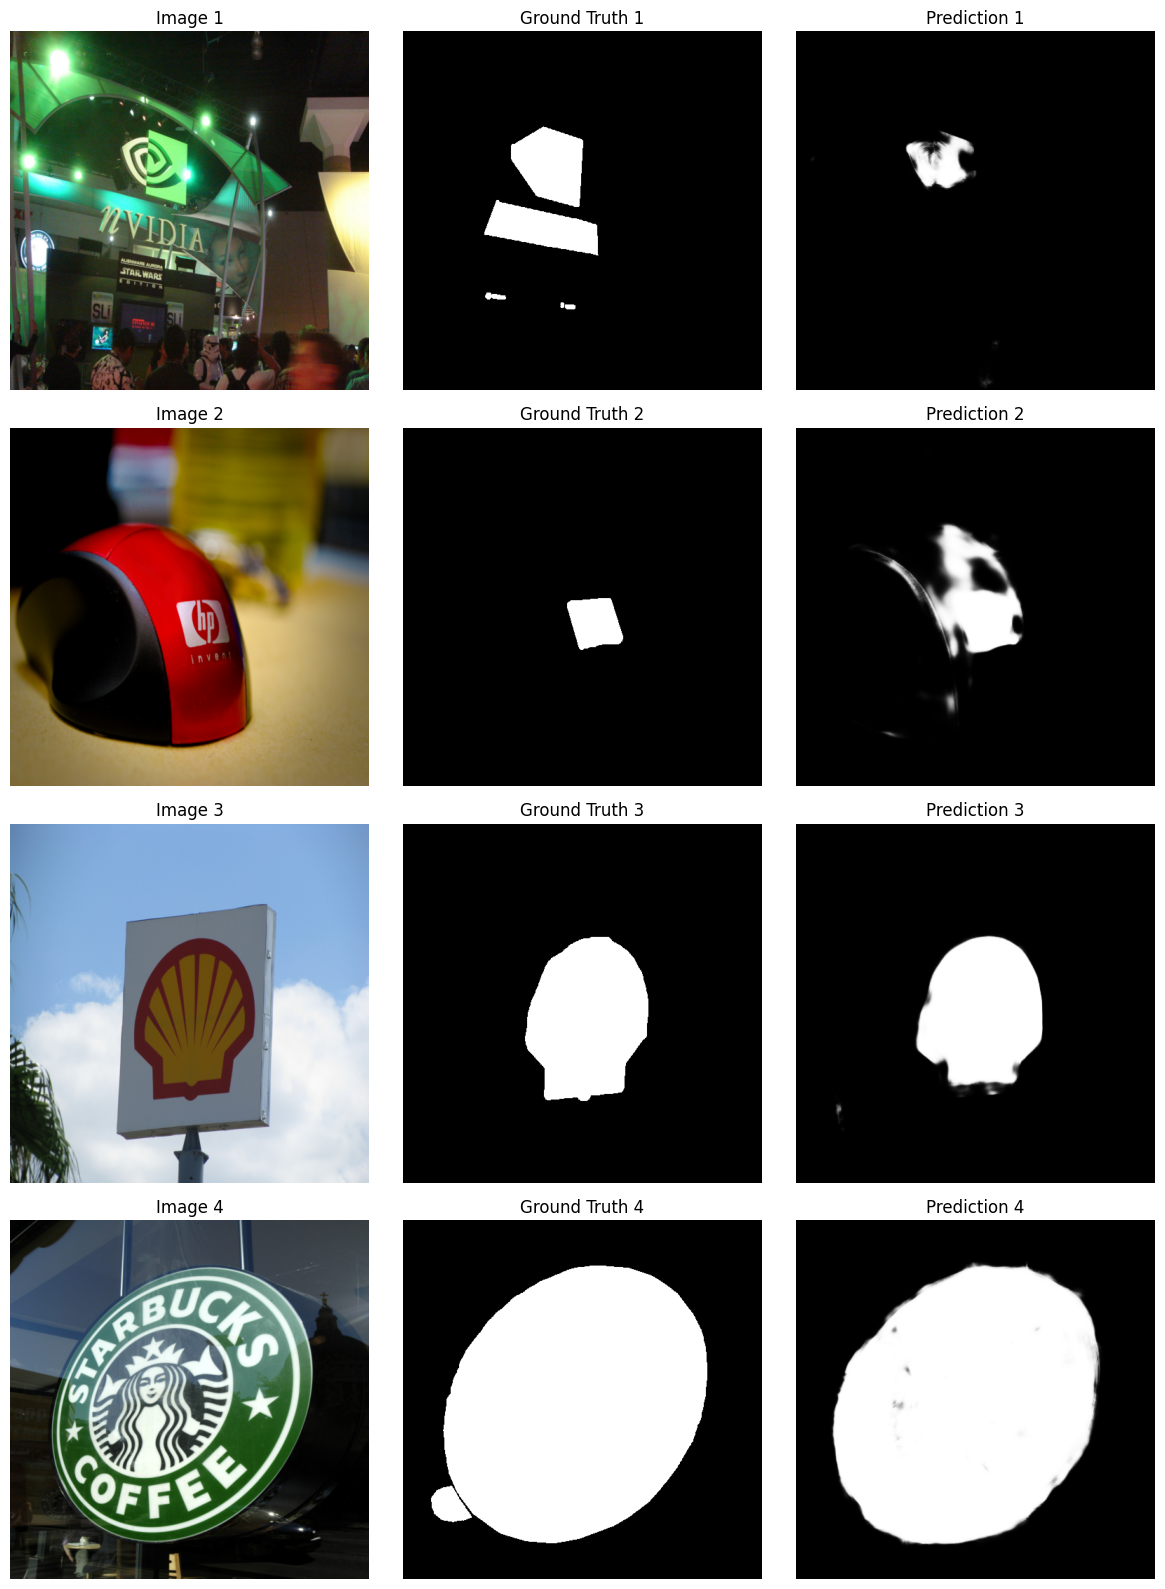

In [17]:
# Visualize predictions on validation set
fig = utils.visualize_predictions(model, val_dataloader, device)
plt.show()

## 11. Save and Export the Model

In [18]:
# Save the trained model for future use
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'image_size': image_size,
        'n_channels': 3,
        'n_classes': 1,
        'bilinear': True,
        'base_channels': 64
    }
}, 'results/logo_detection_model.pth')

print("Model saved to 'results/logo_detection_model.pth'")

Model saved to 'results/logo_detection_model.pth'


## 12. Inference on New Images

This section demonstrates how to use the trained model for inference on new images.

In [19]:
# Function to predict on new images
def predict_logo(image_path, model, device, image_size=512, threshold=0.5):
    # Load and preprocess the image
    image_tensor, pred = utils.predict_single_image(model, image_path, device, image_size)
    
    # Apply threshold to get binary mask
    binary_mask = (pred > threshold).float()
    
    # Overlay the mask on the image
    overlaid = utils.overlay_mask(image_tensor, pred, alpha=0.5)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display original image
    axes[0].imshow(image_tensor.permute(1, 2, 0).numpy())
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display prediction probability
    axes[1].imshow(pred.numpy(), cmap='jet')
    axes[1].set_title('Prediction Probability')
    axes[1].axis('off')
    
    # Display overlaid result
    axes[2].imshow(overlaid)
    axes[2].set_title('Overlaid Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return image_tensor, pred, binary_mask

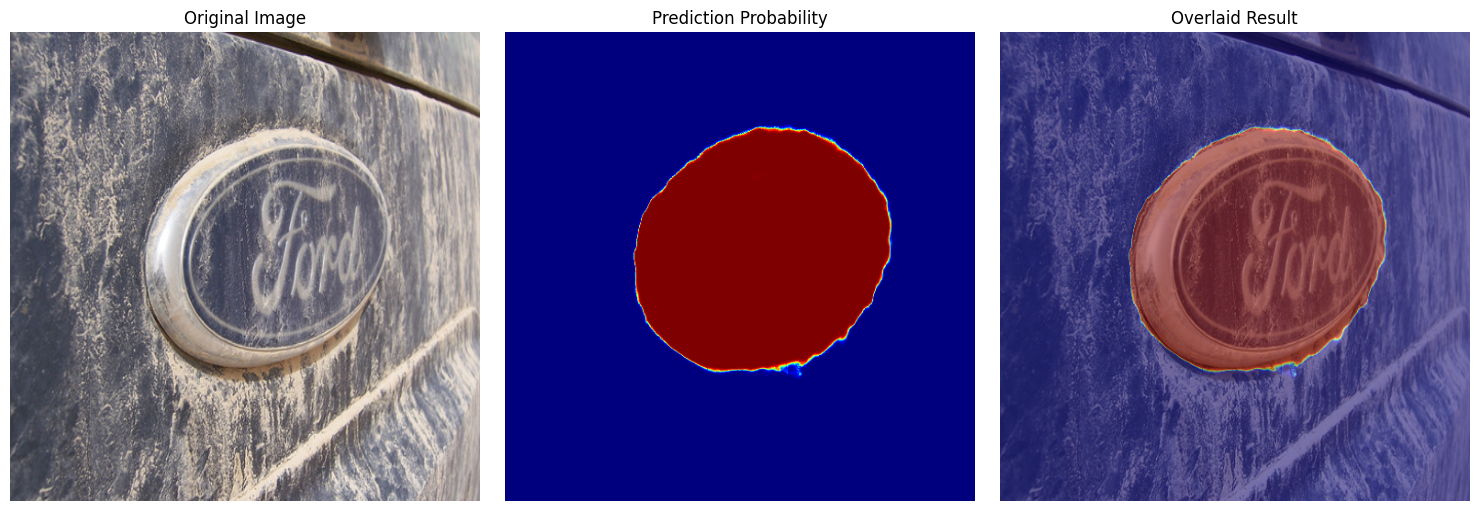

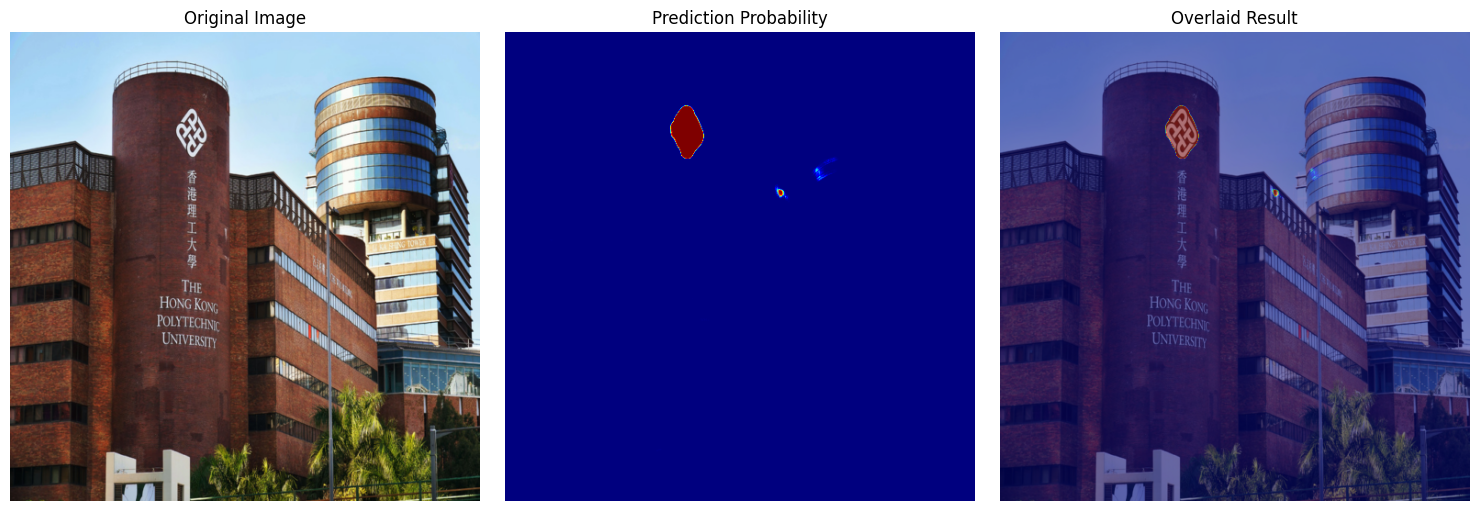

In [21]:
# Example of inference - you'll need to provide a test image path
test_image_path1 = './test_img/test1.png'
image, pred, mask = predict_logo(test_image_path1, model, device)
test_image_path2 = './test_img/test2.png'
image, pred, mask = predict_logo(test_image_path2, model, device)

## 14. Clean Up and Conclusion

In [22]:
# Finish wandb logging if it's active
if wandb.run is not None:
    wandb.finish()

print("Pipeline completed successfully!")

Pipeline completed successfully!
